In [85]:
import pandas as pd

passengers = pd.read_csv("Data/train.csv")
passengers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [86]:
from sklearn.model_selection import train_test_split

X = passengers.drop(columns=["Survived"])
Y = passengers["Survived"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1)

In [87]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer


class DropColumnTranformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(columns=self.columns, axis=1, errors="ignore")
    
    def get_feature_names_out(self, input_features=None):
        return None
    
    
    
class SumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column1, column2):
        self.column1 = column1
        self.column2 = column2
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return (X[self.column1] + X[self.column2]).to_frame()
    
    def get_feature_names_out(self, input_features=None):
        return ["Family"]
    
    
class AgeGroupTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="Age"):
        self.age_bins = [0, 3, 12, 20, 40, 60, 200]
        self.age_labels = ["toddler", "child", "teen", "young-adult", "middle-adult", "senior"]
        self.column = column
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=[self.column])
        X["AgeGroup"] = pd.cut(X[self.column], bins=self.age_bins, labels=self.age_labels)
        return X[["AgeGroup"]].astype(str).to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return ["AgeGroup"]
        
        
class DeckExctractorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=[self.column])
        X["Deck"] = X[self.column].str[0]
        X["Deck"].fillna("N", inplace=True)
        return X[["Deck"]].to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return ["Deck"]        
        
        
log_transformer = FunctionTransformer(np.log, feature_names_out="one-to-one")

In [88]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

binary_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                OneHotEncoder())

age_group_pipeline = make_pipeline(SimpleImputer(strategy="mean"),
                                   AgeGroupTransformer(),
                                   OneHotEncoder(handle_unknown="ignore"))

family_pipeline = make_pipeline(SumTransformer("SibSp", "Parch"))

log_pipeline = make_pipeline(SimpleImputer(missing_values=0, strategy="median"),
                             SimpleImputer(strategy="median"),
                             log_transformer,
                             StandardScaler())

deck_pipeline = make_pipeline(DeckExctractorTransformer("Cabin"),
                              OneHotEncoder(handle_unknown="ignore"))

num_pipeline = make_pipeline(SimpleImputer(strategy="mean"),
                             StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore"))

drop_pipeline = make_pipeline(DropColumnTranformer(["Name", "Ticket", "SibSp", "Parch", "PassengerId"]))

In [89]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer([
    ("sex", binary_pipeline, ["Sex"]),
    ("age_group", age_group_pipeline, ["Age"]),
    ("family", family_pipeline, ["SibSp", "Parch"]),
    ("fare", log_pipeline, ["Fare"]),
    ("deck", deck_pipeline, ["Cabin"]),
    ("drop", drop_pipeline, ["Name", "Ticket", "SibSp", "Parch", "PassengerId"]),
    ("cat", cat_pipeline, ["Embarked"]),
    ("num", num_pipeline, ["Age"])
], remainder="passthrough")

In [90]:
x_train_transformed = preprocessing.fit_transform(x_train)
feature_names = preprocessing.get_feature_names_out()
feature_names

array(['sex__Sex_female', 'sex__Sex_male', 'age_group__AgeGroup_child',
       'age_group__AgeGroup_middle-adult', 'age_group__AgeGroup_senior',
       'age_group__AgeGroup_teen', 'age_group__AgeGroup_toddler',
       'age_group__AgeGroup_young-adult', 'family__Family', 'fare__Fare',
       'deck__Deck_A', 'deck__Deck_B', 'deck__Deck_C', 'deck__Deck_D',
       'deck__Deck_E', 'deck__Deck_F', 'deck__Deck_G', 'deck__Deck_N',
       'deck__Deck_T', 'cat__Embarked_C', 'cat__Embarked_Q',
       'cat__Embarked_S', 'num__Age', 'remainder__Pclass'], dtype=object)

In [91]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from aquarel import load_theme


def plot_learning_curves(models_list: list, x, y, cv=5, size=10):
    n_models = len(models_list)
    n_columns = 3  # Define number of columns
    n_rows = (n_models + n_columns - 1) // n_columns

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(15, n_rows * 5))
    axs = np.array(axs).reshape(n_rows, n_columns)
    
    theme = load_theme("boxy_dark")
    theme.set_color(figure_background_color="#181818",
                    plot_background_color="#242424")
    theme.set_font(family="monospace", size=9)
    theme.apply_transforms()
    theme.apply()

    for i, (model, model_name) in enumerate(models_list):

        train_sizes, train_scores, test_scores = learning_curve(
            estimator=model,
            X=x,
            y=y,
            train_sizes=np.linspace(0.1, 1.0, size),
            cv=cv,
            scoring='accuracy'
        )

        row, col = divmod(i, n_columns)
        ax = axs[row, col]
        ax.plot(train_sizes, train_scores.mean(axis=1), label="Train", marker="o")
        ax.plot(train_sizes, test_scores.mean(axis=1), label="Test", marker="s")
        ax.set_title(model_name)
        ax.legend()
    
    fig.supxlabel("Samples in training set")
    fig.supylabel("Accuracy")

    # Remove the remainder empty subplots
    for i in range(n_models, n_rows * n_columns):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()


In [92]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models_list = [
    (LogisticRegression(), "LogisticRegression"),
    (LogisticRegressionCV(), "LogisticRegressionCV"),
    (SGDClassifier(), "SGDClassifier"),
    (SVC(), "SVC"),
    (DecisionTreeClassifier(), "DecisionTreeClassifier"),
    (RandomForestClassifier(), "RandomForestClassifier"),
]

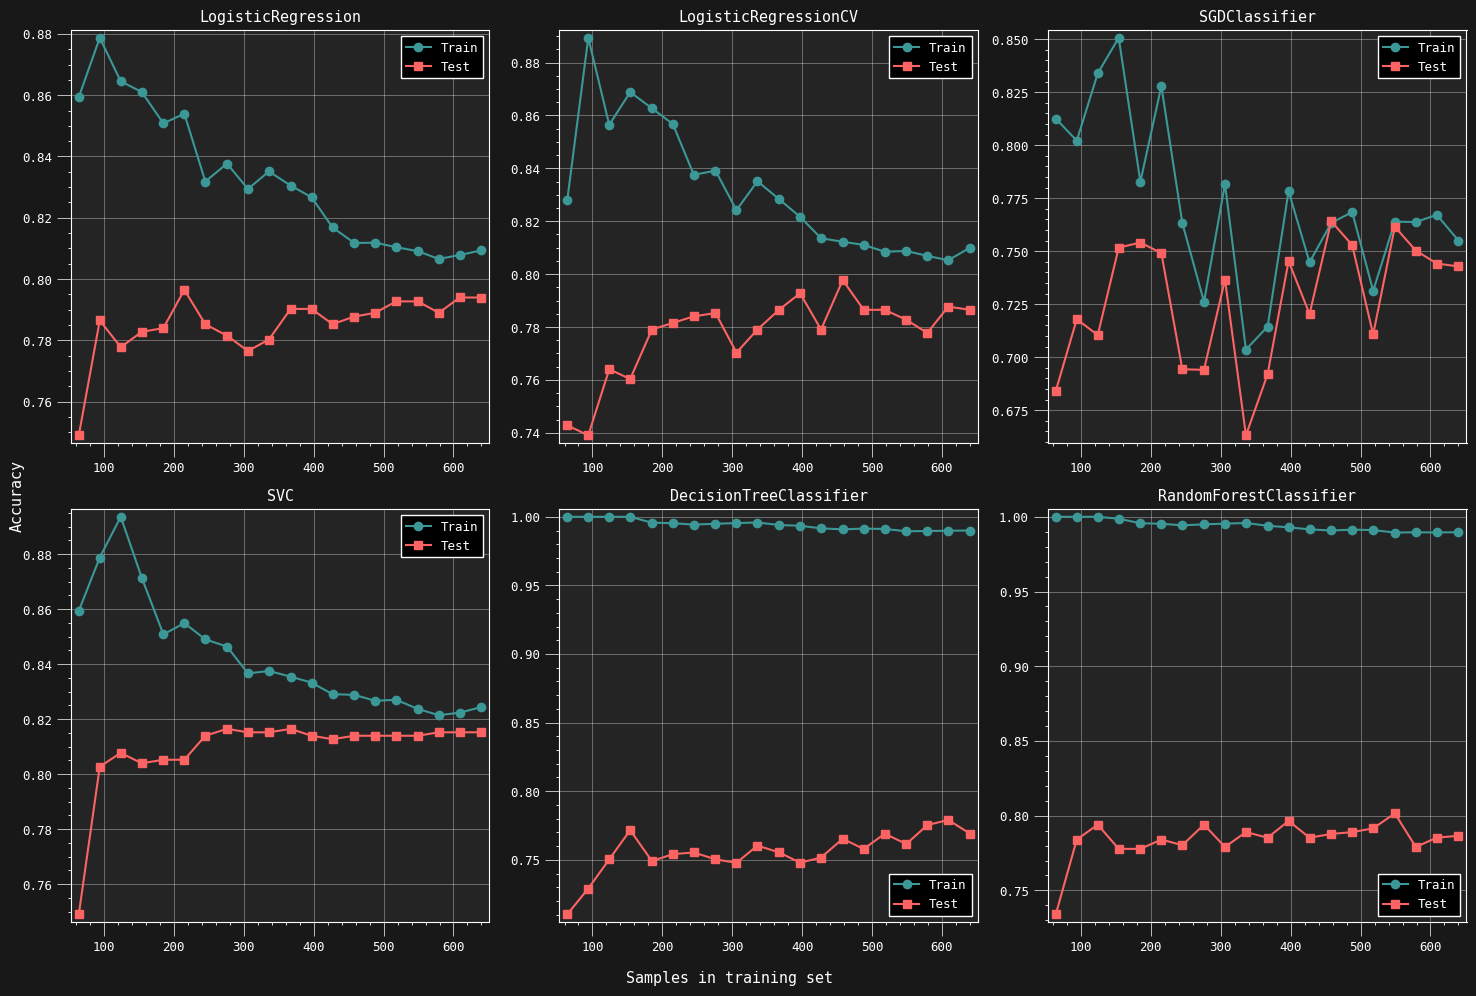

In [93]:
plot_learning_curves(models_list=models_list,
                     x=x_train_transformed,
                     y=y_train,
                     size=20)